## *Emotional Dataset using Gloabl Average Pooling, NLP*

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Download datasets and assign the columns

In [6]:
# Dividing the dataset into train, test & validation set
# Load Data
url_train = '/kaggle/input/emotions-dataset-for-nlp/train.txt'
url_test = '/kaggle/input/emotions-dataset-for-nlp/test.txt'
url_val = '/kaggle/input/emotions-dataset-for-nlp/val.txt'

df_train = pd.read_csv(url_train, sep=';', names=['text', 'emotion'])
df_test = pd.read_csv(url_test, sep=';', names=['text', 'emotion'])
df_val = pd.read_csv(url_val, sep=';', names=['text', 'emotion'])

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(16000, 2)
(2000, 2)
(2000, 2)


## *EDA*

We will viusalize our data. We will proceed with using Pie charts.

-----------------------------------------------------------------------------------


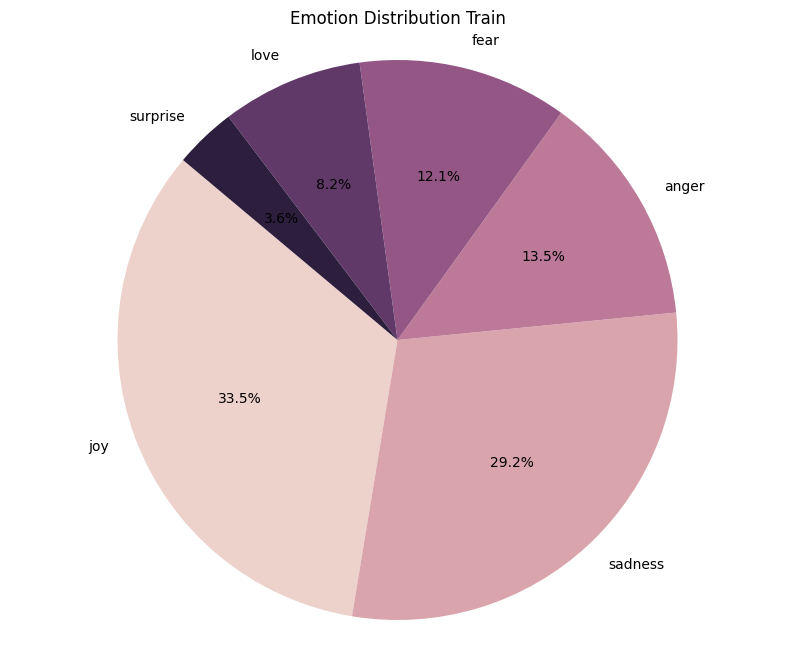

-----------------------------------------------------------------------------------


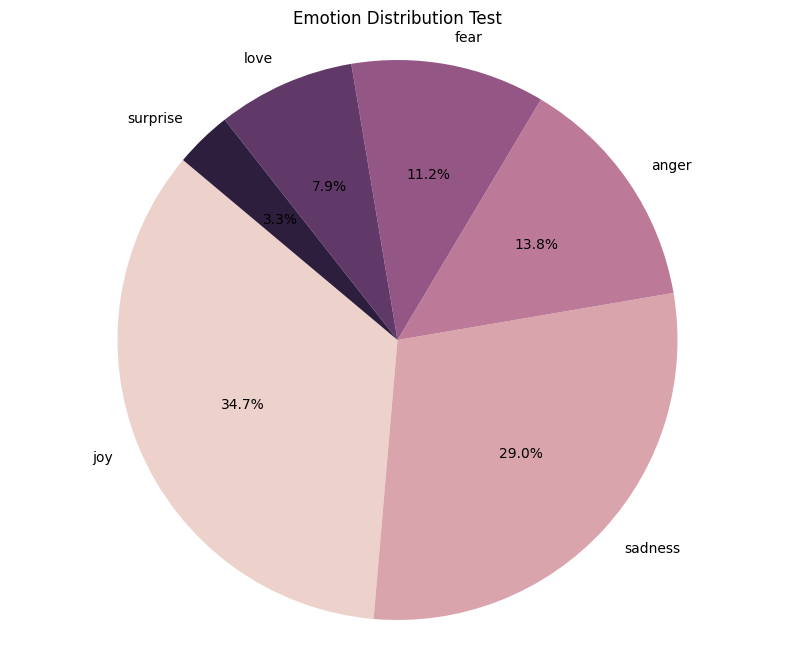

------------------------------------------------------------------------------------


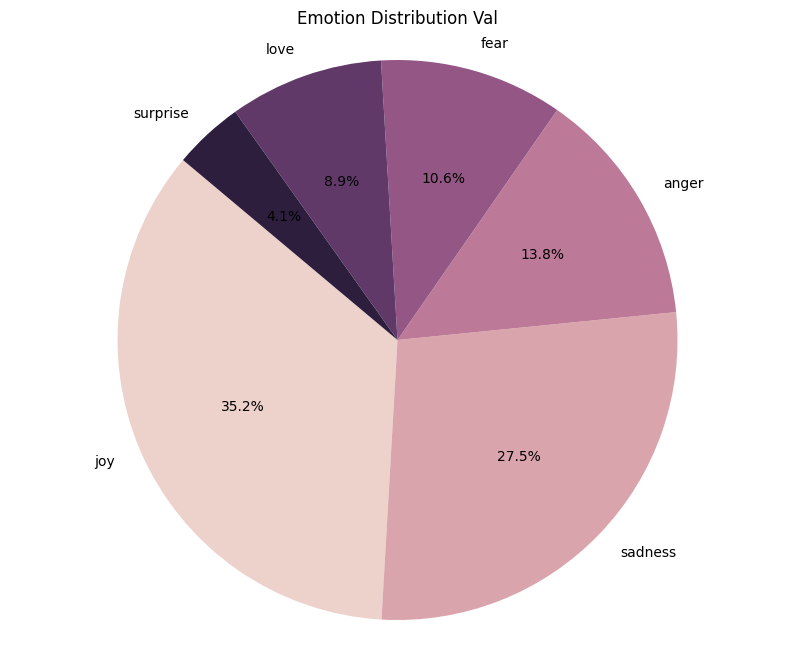

In [9]:
def plot_emotion_distributor(df, column_name= "emotion", title="Emotion Distribution"):
    label_counts = df[column_name].value_counts()
    light_colors = sns.cubehelix_palette(n_colors=len(label_counts))
    # Plotting the chart
    plt.figure(figsize=(10,8))
    plt.pie(
        label_counts,
        labels = label_counts.index,
        autopct = "%1.1f%%",
        startangle = 140,
        colors = light_colors
    )
    plt.title(title)
    plt.axis('equal')
    plt.show()
    
# Plot charts
print('-----------------------------------------------------------------------------------')
plot_emotion_distributor(df_train,column_name='emotion',title='Emotion Distribution Train')
print('-----------------------------------------------------------------------------------')
plot_emotion_distributor(df_test,column_name='emotion',title='Emotion Distribution Test')
print('------------------------------------------------------------------------------------')
plot_emotion_distributor(df_val,column_name='emotion',title='Emotion Distribution Val')

### As we can observe the dominant emotions in the dataset are *Joy, Sadness, Anger & Fear*. We will work on these 4 emotions first.
- Working with dominant class of emotions helps ensures we have enough data to train our model.

Function to filter for different emotions.

In [10]:
# Combine datasets
df = pd.concat([df_train, df_test, df_val]).reset_index(drop=True)

In [ ]:
df.shape

In [11]:
df.columns

Index(['text', 'emotion'], dtype='object')

In [106]:
# # Filtering emotions
# def filter_emotions(df, column='emotion', exclude_emotions=['love', 'surprise']):
#     return df[~df[column].isin(exclude_emotions)]

# df_train = filter_emotions(df_train)
# df_test = filter_emotions(df_test)
# df_val = filter_emotions(df_val)

In [127]:
# joy = df_train[df_train['emotion']=='joy'].sample(n=2100, random_state=20)
# sad = df_train[df_train['emotion']=='sadness'].sample(n=2200, random_state=20)
# fear = df_train[df_train['emotion']=='fear'].sample(n=1937, random_state=20)
# anger = df_train[df_train['emotion']=='anger'].sample(n=2159, random_state=20)

# # Make it into one dataset
# df_sampled = pd.concat([joy, sad, fear, anger]).reset_index(drop=True)

# # Check the dataset
# df_sampled.tail()

,text,emotion,label
8391,essentially least mind solved design problem f...,anger,0
8392,feel like ask stay im selfish one even though ...,anger,0
8393,promised wont enter anymore giveaway feel gree...,anger,0
8394,im typing im blowing nose feeling extremely cr...,anger,0
8395,sat windy beach feeling thoroughly annoyed vow...,anger,0


In [128]:
# df_train = df_sampled.sample(frac=1, random_state=42)
# df_train.tail()

,text,emotion,label
5734,remember feeling uncertain say well erm trying...,fear,1
5191,alone cottage often stay woken rustling sound ...,fear,1
5390,climbed cherry tree alone thick caterpillar be...,fear,1
860,feel im much productive get less distracted fe...,joy,2
7270,might able recreate feeling get back cold fog ...,anger,0


### Preprocess and cleaning the dataset

In [13]:
# Preprocess Function
def preprocess(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))
    df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
    df['text'] = df['text'].str.replace(r'\n|\t', ' ', regex=True)
    df['text'] = df['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
    df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
    df['text'] = df['text'].str.strip()

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    return df

# Check the new dataframe
preprocess(df)


,text,emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
19995,im ssa examination tomorrow morning im quite w...,sadness
19996,constantly worry fight nature push limit inner...,joy
19997,feel important share info experience thing,joy
19998,truly feel passionate enough something stay tr...,joy


In [14]:
# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['emotion'])

In [15]:
# Tokenize
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(df['text']), maxlen=max_len, padding='post')
y = df['label'].values

In [16]:
# Train/Validation Split (stratified)
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
# One-hot encode labels
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

In [20]:
# Sequential Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [ ]:
### Now lets make predictions

In [21]:
# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=callbacks)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3303 - loss: 1.5944 - val_accuracy: 0.3380 - val_loss: 1.5716
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3421 - loss: 1.5650 - val_accuracy: 0.3380 - val_loss: 1.5651
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3485 - loss: 1.5562 - val_accuracy: 0.3380 - val_loss: 1.5575
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3598 - loss: 1.5550 - val_accuracy: 0.3380 - val_loss: 1.5352
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4207 - loss: 1.4741 - val_accuracy: 0.5865 - val_loss: 1.3319
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5376 - loss: 1.2541 - val_accuracy: 0.6018 - val_loss: 1.0549
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6778 - loss: 0.9373 - val_accuracy: 0.8060 - val_loss: 0.7421
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7745 - loss: 0.7036 - val_accuracy: 0.

In [22]:
# Evaluate
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [23]:
# Getting the accuracy, precision and other key matrix scores
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.8685
Precision: 0.8699621766305558
Recall: 0.8685
F1 Score: 0.8629305699088221

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.78      0.84       542
        fear       0.76      0.85      0.80       475
         joy       0.91      0.93      0.92      1352
        love       0.81      0.73      0.77       328
     sadness       0.87      0.95      0.91      1159
    surprise       0.87      0.31      0.46       144

    accuracy                           0.87      4000
   macro avg       0.85      0.76      0.78      4000
weighted avg       0.87      0.87      0.86      4000


Confusion Matrix:
[[ 425   23   16    4   74    0]
 [  11  403    4    3   50    4]
 [   7   10 1258   42   33    2]
 [   8    4   67  241    7    1]
 [  15   16   26    0 1102    0]
 [   2   75    9    9    4   45]]


# Making a confusion matrix with seaborn

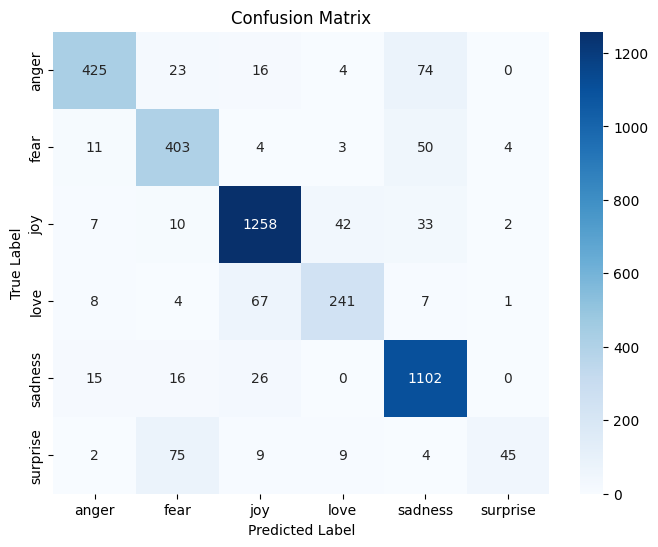

In [28]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()